# Hello
This one is using a different word embedding called word2vec.

Articles/Sourcecode referenced \
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model \
https://radimrehurek.com/gensim/models/keyedvectors.html \
https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92 \
https://towardsdatascience.com/word2vec-for-phrases-learning-embeddings-for-more-than-one-word-727b6cf723cf \
https://www.analyticsvidhya.com/blog/2020/08/information-retrieval-using-word2vec-based-vector-space-model/#:~:text=End%20Notes-,What%20is%20Information%20Retrieval%3F,in%20the%20information%20retrieval%20system. \
http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XEjbvM9KjJw \
https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72 \
http://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.WuiiKtMvyds \
https://github.com/Suji04/NormalizedNerd/tree/master/Introduction%20to%20NLP \
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html \
https://towardsdatascience.com/visualizing-word-embedding-with-pca-and-t-sne-961a692509f5 \
https://github.com/marcellusruben/Word_Embedding_Visualization \
https://radimrehurek.com/gensim/models/phrases.html

In [1]:
# using Python version 3.8.5
from platform import python_version
python_version()

'3.7.12'

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!pip install sklearn
!pip install nltk
!pip install gensim
!pip install numpy
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# 1. Importing Packages

In [1]:
# importing main packages
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import gensim
import nltk

# import for shorthand / specific uses
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics

# import graphics
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

## wordnet corpus to be downloaded for lemmatization
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 2. Data Ingestion and Preprocessing

In [2]:
xls = pd.ExcelFile('/content/drive/MyDrive/Capstone/Dataset/ProjectsData.xlsx')

df1 = pd.read_excel(xls, 'Parcel F')
df2 = pd.read_excel(xls, 'SIS')
df3 = pd.read_excel(xls, 'LRT3')
df4 = pd.read_excel(xls, 'Belfield')
df5 = pd.read_excel(xls, 'CP2')
df6 = pd.read_excel(xls, 'TNB')
df7 = pd.read_excel(xls, 'PNLC')
df8 = pd.read_excel(xls, 'SMC4')

frames =[df1,df2,df3,df4,df5,df6,df7,df8]

data = pd.concat(frames)
data = data['task_name']
data

0       F2 BIM Development - Level 6
1                    F2 CA - Level 5
2                    F2 CA - Level 7
3                    F2 FM - Level 3
4                    F2 FM - Level 8
                    ...             
3867      Slab & Column L8 : Zone 1a
3868      Slab & Column L9 : Zone 1a
3869     Slab & Column L10 : Zone 1a
3870     Slab & Column L11 : Zone 1a
3871    Slab & Column Roof : Zone 1a
Name: task_name, Length: 50347, dtype: object

In [3]:
# removing punctuation with pandas(str.replace) and regex
data_nopunc = data
data_nopunc = data_nopunc.str.replace('[^\w\s]',' ')

# filling all nan values with blanks
data_nopunc = data_nopunc.fillna('')

# removing all standalone numbers
def no_nums(col):
    return ' '.join(filter(lambda word:word.replace('.','').isdigit()==False, col.split()))

data_nopunc = data_nopunc.apply(no_nums)
data_nopunc

0       F2 BIM Development Level
1                    F2 CA Level
2                    F2 CA Level
3                    F2 FM Level
4                    F2 FM Level
                  ...           
3867      Slab Column L8 Zone 1a
3868      Slab Column L9 Zone 1a
3869     Slab Column L10 Zone 1a
3870     Slab Column L11 Zone 1a
3871    Slab Column Roof Zone 1a
Name: task_name, Length: 50347, dtype: object

In [4]:
# corpus description
length_of_the_messages = data_nopunc.str.split("\\s+")

print(length_of_the_messages)
print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())
print("Min number of words = ", length_of_the_messages.str.len().min())
print("Index = ", length_of_the_messages.str.len().idxmin())


# maximum of number of words = 15
# minimum number of words = 1
# number of documents = 50347

0        [F2, BIM, Development, Level]
1                      [F2, CA, Level]
2                      [F2, CA, Level]
3                      [F2, FM, Level]
4                      [F2, FM, Level]
                     ...              
3867      [Slab, Column, L8, Zone, 1a]
3868      [Slab, Column, L9, Zone, 1a]
3869     [Slab, Column, L10, Zone, 1a]
3870     [Slab, Column, L11, Zone, 1a]
3871    [Slab, Column, Roof, Zone, 1a]
Name: task_name, Length: 50347, dtype: object
Max number of words =  15
Index =  543
Min number of words =  1
Index =  1231


In [5]:
# function to lowercase the words
def lowercasing(text):
    '''a function for lowercasing'''
    text = [word.lower() for word in text.split()]
    # joining the list of words with space separator
    return " ".join(text)

# lemmatizing function
lemmatizer = WordNetLemmatizer()

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]




In [6]:
# lowercase the words
data_lower = data_nopunc
data_lower = data_lower.apply(lowercasing)
data_lower.head(20)


0             f2 bim development level
1                          f2 ca level
2                          f2 ca level
3                          f2 fm level
4                          f2 fm level
5               f2 l02 dd review archi
6               f2 l03 dd review archi
7             f2 bim development level
8             f2 bim development level
9             f2 bim development level
10            f2 l05 dd approval archi
11    f2 l07 dd submission batch archi
12            f2 l07 dd approval archi
13            f2 l08 dd approval archi
14                         f2 ca level
15                         f2 ca level
16                         f2 ca level
17                         f2 fm level
18                         f2 fm level
19                         f2 fm level
Name: task_name, dtype: object

In [7]:
# lemmatizing the text
data_lemmatize = data_lower
data_lemmatize = data_lemmatize.apply(lemmatize_text)
data_lemmatize = data_lemmatize.str.join(' ')
data_lemmatize.head(20)

0             f2 bim development level
1                          f2 ca level
2                          f2 ca level
3                          f2 fm level
4                          f2 fm level
5               f2 l02 dd review archi
6               f2 l03 dd review archi
7             f2 bim development level
8             f2 bim development level
9             f2 bim development level
10            f2 l05 dd approval archi
11    f2 l07 dd submission batch archi
12            f2 l07 dd approval archi
13            f2 l08 dd approval archi
14                         f2 ca level
15                         f2 ca level
16                         f2 ca level
17                         f2 fm level
18                         f2 fm level
19                         f2 fm level
Name: task_name, dtype: object

In [8]:
#data with numbers
data_num = data_lemmatize

# converting the data to list format to prepare for tokenization
listing_num = data_num.tolist()

In [9]:
# tokenizing the data to prepare for word2vec modelling
tokens_num = [word_tokenize(i) for i in listing_num]
tokens_num

[['f2', 'bim', 'development', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'l02', 'dd', 'review', 'archi'],
 ['f2', 'l03', 'dd', 'review', 'archi'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'l05', 'dd', 'approval', 'archi'],
 ['f2', 'l07', 'dd', 'submission', 'batch', 'archi'],
 ['f2', 'l07', 'dd', 'approval', 'archi'],
 ['f2', 'l08', 'dd', 'approval', 'archi'],
 ['f2', 'ca', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'ca', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'fm', 'level'],
 ['f2', 'bim', 'development', 'level'],
 ['f2', 'l04', 'dd', 'approval', 'archi'],
 ['f2', 'l05', 'dd', 'preparation', 'archi'],
 ['f2', 'l07', 'dd', 'preparation', 'archi'],
 ['f2', 'l04', 'dd', 'review', 'id'],
 ['f2', 'l06', 'dd', 'review', 'id'],
 ['f2', 'l08', 'dd', 'preparation', 'id'],
 ['f2', 'bim', 'd

In [10]:
# Number of tokens
count = 0
for listElem in tokens_num:
    count += len(listElem)                    
print('Total Number of elements : ', count)

Total Number of elements :  256556


A dataset without numeric characters was also made for comparison.

In [11]:
### dataset without numeric characters
#Removing all non-alpha characters
data_clean = data_lemmatize
data_clean = data_clean.str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()

#data without numbers
data_alpha = data_clean

# converting the data to list format
listing_alpha = data_alpha.tolist()

# tokenizing the data to prepare for word2vec modelling
tokens_alpha = [word_tokenize(i) for i in listing_alpha]



In [12]:
# Training Word2Vec model
modelNum = gensim.models.Word2Vec(tokens_num, vector_size=200, sg=1, epochs=10)
modelAlp = gensim.models.Word2Vec(tokens_alpha, vector_size=200, sg=1, epochs=10)

In [13]:
# listing 30 vocabulary in Word2vec models
print("Word2vec Numeric Model First 30 Vocabulary")
for index, word in enumerate(modelNum.wv.index_to_key):
    if index == 30:
        print("\n")
        break
    print(f"modelNum word #{index}/{len(modelNum.wv.index_to_key)} is {word}")

print("Word2vec Alpha Model First 30 Vocabulary")
for index, word in enumerate(modelAlp.wv.index_to_key):
    if index == 30:
        break
    print(f"modelAlp word #{index}/{len(modelAlp.wv.index_to_key)} is {word}")

Word2vec Numeric Model First 30 Vocabulary
modelNum word #0/1752 is fix
modelNum word #1/1752 is 3rd
modelNum word #2/1752 is 2nd
modelNum word #3/1752 is c
modelNum word #4/1752 is 1st
modelNum word #5/1752 is rc
modelNum word #6/1752 is level
modelNum word #7/1752 is slab
modelNum word #8/1752 is zone
modelNum word #9/1752 is fitting
modelNum word #10/1752 is ar
modelNum word #11/1752 is plumbing
modelNum word #12/1752 is system
modelNum word #13/1752 is conduit
modelNum word #14/1752 is a
modelNum word #15/1752 is bs
modelNum word #16/1752 is electrical
modelNum word #17/1752 is column
modelNum word #18/1752 is l01
modelNum word #19/1752 is room
modelNum word #20/1752 is fire
modelNum word #21/1752 is s
modelNum word #22/1752 is me
modelNum word #23/1752 is l03
modelNum word #24/1752 is floor
modelNum word #25/1752 is door
modelNum word #26/1752 is l02
modelNum word #27/1752 is work
modelNum word #28/1752 is wall
modelNum word #29/1752 is water


Word2vec Alpha Model First 30 Vocabu

In [14]:
#Checking vocabulary index and sizes
fitting_idx = modelNum.wv.key_to_index["fitting"]
fitting_cnt = modelNum.wv.get_vecattr("fitting", "count")
print('Vocabulary size:', len(modelNum.wv))
print('Fitting:', fitting_idx, fitting_cnt)

# Vocabulary size of the corpus is 1752
# the word 'fitting' is in index 9 and has 2798 occurrences

Vocabulary size: 1752
Fitting: 9 2798


In [15]:
# word2vec vector representation of the word 'fitting'
vec_fitting = modelNum.wv['fitting']
vec_fitting

array([ 0.8917581 , -0.26745602, -0.4953452 , -0.11812675,  0.5620022 ,
       -0.38975146,  0.40201607,  0.6086641 , -0.17055947,  0.8621357 ,
       -0.08964509, -0.17670195,  0.23799133,  1.0040419 , -0.10586698,
       -0.4983136 ,  0.11118682,  0.17965023,  0.20736587, -0.9173738 ,
       -0.4410182 ,  0.08628155, -0.36307362, -0.20932278,  0.01223871,
        0.46417952, -0.7067366 , -0.16438225, -0.6040461 ,  0.12987757,
        0.6372586 ,  0.17789799,  0.01122581, -0.04974115, -0.24193576,
       -0.16870892,  0.45672575,  0.4904948 ,  0.01773359, -0.211912  ,
       -0.46782678, -0.4759906 ,  0.30576238,  0.13339125,  0.3597914 ,
       -0.5067171 , -0.05160079, -0.3357096 ,  0.28196976, -0.27208367,
       -0.37975457,  0.41397348,  0.2378124 ,  0.24066181,  0.47521687,
       -0.01804315,  0.299288  ,  0.01589378, -0.05731981, -0.13373409,
       -0.06185044,  0.1555205 ,  0.23825622,  0.69444585, -0.40630051,
       -0.14286064, -0.13020195,  0.13645114, -0.2600748 ,  0.19

In [16]:
# seeing word similarity between two words
modelNum.wv.similarity('drawing','dwg')

0.5261289

In [17]:
# top n closest words to w1
w1='level'
modelNum.wv.most_similar (positive=w1, topn=20)

[('basement', 0.5933492183685303),
 ('p2a', 0.5439032316207886),
 ('mezz', 0.5015619993209839),
 ('p3a', 0.4959937632083893),
 ('cl09', 0.4840295612812042),
 ('eb2', 0.48151370882987976),
 ('al16', 0.48103511333465576),
 ('bl11', 0.48043304681777954),
 ('al04', 0.4803965389728546),
 ('al12', 0.4797098636627197),
 ('bl10', 0.477079302072525),
 ('cl04', 0.47669094800949097),
 ('al06', 0.4759238362312317),
 ('cgf', 0.4741756319999695),
 ('semi', 0.47325599193573),
 ('al11', 0.4721744656562805),
 ('dgf', 0.470761775970459),
 ('al10', 0.47018229961395264),
 ('acb2', 0.47001293301582336),
 ('al07', 0.46969714760780334)]

# Using Word2vec with Phraser

In [18]:
# gensim Phraser model is built to handle bigrams and trigrams
def build_phrases(sentences):
    phrases = Phrases(sentences,
                      min_count=5,
                      threshold=3,
                      progress_per=1000,
                      connector_words=ENGLISH_CONNECTOR_WORDS)
    return Phraser(phrases)

phrasesNum=build_phrases(tokens_num)
phrasesAlp=build_phrases(tokens_alpha)

In [19]:
for phrase, score in phrasesNum.find_phrases(tokens_num).items():
    print(phrase, score)

bim_development 25.979428721174003
dd_review 20.340711805555554
dd_approval 7.682642948141487
dd_submission 8.262184679239201
dd_preparation 14.3340586549217
sh_approval 7.214925389065602
sh_review 19.102373887240354
sh_preparation 13.461404417182802
sh_submission 7.759184751103433
cn_preparation 49.14534395973154
f2_abortive 5.487062404870625
branch_duct 8.57092654722911
fire_protection 9.12216166451565
branch_pipe 11.562888208434952
demountable_wall 11.121648565731817
bp_approval 4.05238309352518
commencement_of_mechanical 4.096675551147751
commencement_of_fft 5.504122366265997
main_pipe 4.043990528830623
electrical_fft 7.389909745162813
main_conduit 3.576574183186298
conduit_wiring 3.000043929717402
signing_by_pbsb 100.13888888888889
electrical_pa 8.542695724326435
walk_through 250.3472222222222
end_user 616.2393162393163
commencement_of_id 5.296174413821473
mock_up 83.2706369947995
bp_submission 4.358075435203094
preparation_amendment 5.040548098434004
3d_perspective 77.02991452991

In [20]:
## saving and loading the model locally
#phrasesNum.save('phrases_model.txt')
#phrasesNum= Phraser.load('phrases_model.txt')

In [21]:
# Training Word2Vec model
modelNum_phrases = gensim.models.Word2Vec(phrasesNum[tokens_num], vector_size=200, sg=1, epochs=10)
modelAlp_phrases = gensim.models.Word2Vec(phrasesAlp[tokens_alpha], vector_size=200, sg=1, epochs=10)

In [22]:
# listing 30 vocabulary in Word2vec Phrases models
print("Word2vec Numeric Phrases Model First 30 Vocabulary")
for index, word in enumerate(modelNum_phrases.wv.index_to_key):
    if index == 30:
        print("\n")
        break
    print(f"modelNum word #{index}/{len(modelNum_phrases.wv.index_to_key)} is {word}")

print("Word2vec Alpha Phrases Model First 30 Vocabulary")
for index, word in enumerate(modelAlp_phrases.wv.index_to_key):
    if index == 30:
        break
    print(f"modelAlp word #{index}/{len(modelAlp_phrases.wv.index_to_key)} is {word}")

Word2vec Numeric Phrases Model First 30 Vocabulary
modelNum word #0/2320 is fix
modelNum word #1/2320 is 3rd
modelNum word #2/2320 is 2nd
modelNum word #3/2320 is c
modelNum word #4/2320 is 1st
modelNum word #5/2320 is level
modelNum word #6/2320 is slab
modelNum word #7/2320 is fitting
modelNum word #8/2320 is zone
modelNum word #9/2320 is a
modelNum word #10/2320 is column
modelNum word #11/2320 is ar
modelNum word #12/2320 is l01
modelNum word #13/2320 is l02
modelNum word #14/2320 is l03
modelNum word #15/2320 is system
modelNum word #16/2320 is l04
modelNum word #17/2320 is acmv
modelNum word #18/2320 is l06
modelNum word #19/2320 is work
modelNum word #20/2320 is l08
modelNum word #21/2320 is l05
modelNum word #22/2320 is fire_protection
modelNum word #23/2320 is l07
modelNum word #24/2320 is sanitary_plumbing
modelNum word #25/2320 is l09
modelNum word #26/2320 is f2
modelNum word #27/2320 is f3
modelNum word #28/2320 is room
modelNum word #29/2320 is water_plumbing


Word2vec A

In [23]:
w1='rc'
modelNum_phrases.wv.most_similar (positive=w1, topn=20)

[('excavation', 0.8084981441497803),
 ('pile_cutting', 0.8074746131896973),
 ('leancon', 0.6753795742988586),
 ('lp', 0.6315277814865112),
 ('lp_2j', 0.5980158448219299),
 ('stressing', 0.5973389148712158),
 ('ga', 0.5967742204666138),
 ('k8', 0.5958954095840454),
 ('k13', 0.5913116931915283),
 ('d16', 0.590823769569397),
 ('k2', 0.5906974673271179),
 ('h10', 0.5886421203613281),
 ('k12', 0.5869621634483337),
 ('jlp2j_lp', 0.5866933465003967),
 ('b2_lw', 0.586469292640686),
 ('k7', 0.5859643220901489),
 ('j5', 0.5839518904685974),
 ('k9', 0.5832393169403076),
 ('d11', 0.5823726058006287),
 ('waller', 0.5820721983909607)]

# Fasttext Model


In [24]:
# Fasttext

In [25]:
# FastText embedding
from gensim.models import FastText
modelNum_fasttext = FastText(tokens_num, vector_size=200, window=3, sg=1, epochs=10)
modelAlp_fasttext = FastText(tokens_alpha, vector_size=200, window=3, sg=1, epochs=10)

In [26]:
# listing 30 vocabulary in FastText numeric model
print("FastText Model First 30 Vocabulary")
for index, word in enumerate(modelNum_fasttext.wv.index_to_key):
    if index == 30:
        print("\n")
        break
    print(f"modelNum word #{index}/{len(modelNum_fasttext.wv.index_to_key)} is {word}")
    
# listing 30 vocabulary in FastText alpha model
print("FastText Model First 30 Vocabulary")
for index, word in enumerate(modelAlp_fasttext.wv.index_to_key):
    if index == 30:
        print("\n")
        break
    print(f"modelNum word #{index}/{len(modelAlp_fasttext.wv.index_to_key)} is {word}")

FastText Model First 30 Vocabulary
modelNum word #0/1752 is fix
modelNum word #1/1752 is 3rd
modelNum word #2/1752 is 2nd
modelNum word #3/1752 is c
modelNum word #4/1752 is 1st
modelNum word #5/1752 is rc
modelNum word #6/1752 is level
modelNum word #7/1752 is slab
modelNum word #8/1752 is zone
modelNum word #9/1752 is fitting
modelNum word #10/1752 is ar
modelNum word #11/1752 is plumbing
modelNum word #12/1752 is system
modelNum word #13/1752 is conduit
modelNum word #14/1752 is a
modelNum word #15/1752 is bs
modelNum word #16/1752 is electrical
modelNum word #17/1752 is column
modelNum word #18/1752 is l01
modelNum word #19/1752 is room
modelNum word #20/1752 is fire
modelNum word #21/1752 is s
modelNum word #22/1752 is me
modelNum word #23/1752 is l03
modelNum word #24/1752 is floor
modelNum word #25/1752 is door
modelNum word #26/1752 is l02
modelNum word #27/1752 is work
modelNum word #28/1752 is wall
modelNum word #29/1752 is water


FastText Model First 30 Vocabulary
modelNum 

In [27]:
modelNum_fasttext.wv.most_similar("kawasan")

[('sri', 0.9610788226127625),
 ('jalan', 0.9537066221237183),
 ('selatan', 0.9505198001861572),
 ('andalas', 0.9245651960372925),
 ('meru', 0.9210066199302673),
 ('besar', 0.9122024178504944),
 ('taman', 0.9085472822189331),
 ('pasar', 0.8996886014938354),
 ('klang', 0.8930290937423706),
 ('csd', 0.8588849902153015)]

In [28]:
# typos are also detected with fast text model, would be good for similar words in malay
modelNum_fasttext.wv.similarity('casting','kasting')

0.922571

In [29]:
# fasttext also works on words foreign to the corpus
# as an example, 'no_such_word' returns false as it is not in the corpus it was trained on
print("no_such_word" in modelNum_fasttext.wv.key_to_index)

# the Fast Text model can still represent it as a vector
modelNum_fasttext.wv["no_such_word"]


False


array([ 7.06886202e-02, -3.63785066e-02, -1.30165935e-01, -4.57610451e-02,
        1.16492752e-02, -2.54324507e-02,  3.44527178e-02, -3.66386361e-02,
       -5.07241674e-02,  4.83240634e-02, -4.72210087e-02, -2.39221994e-02,
       -3.47912610e-02,  1.57723315e-02, -4.54157852e-02, -8.09588581e-02,
        3.78912278e-02, -9.18016583e-03, -1.20505942e-02, -1.44670354e-02,
       -5.73143773e-02, -4.10126857e-02, -1.25607044e-01, -3.29464152e-02,
        2.97463760e-02,  5.00708297e-02, -2.53674183e-02,  2.58857515e-02,
       -2.11685468e-02,  4.18843552e-02, -3.31492610e-02,  2.12480091e-02,
       -2.04615649e-02,  3.24971713e-02, -6.58149496e-02, -4.14139554e-02,
        6.12804443e-02, -1.06117539e-02,  7.42411613e-03,  6.18448574e-03,
        1.17520737e-02,  3.23135182e-02,  1.47403460e-02, -3.14811468e-02,
        2.59584077e-02, -1.70874000e-02,  4.59330268e-02, -1.76775511e-02,
        6.53666386e-04,  1.08755063e-02,  4.07792628e-02,  1.09069776e-02,
        3.35533731e-02,  

# Visualising similar words with different models

Three models are visualised

1. model = Word2vec base model
2. modelNum_phrases = Word2vec with phraser 
3. model_fasttext = Fast Text model

In [30]:
# Function to append similar words to a list
def append_list(sim_words, words):
    
    list_of_words = []
    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

# Function to create a 2D TSNE scatterplot of similar words
def display_tsne_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, perplexity = 0, learning_rate = 0, iteration = 0, topn=5, sample=10):

    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv ]
    
    word_vectors = np.array([model.wv[w] for w in words])
    
    two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]
    #three_dim = TSNE(n_components = 3, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:3]


    # For 2D/3D change the n_dim variable into the following:
    # two_dim = TSNE(n_components = 2, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:2]
    # three_dim = TSNE(n_components = 3, random_state=0, perplexity = perplexity, learning_rate = learning_rate, n_iter = iteration).fit_transform(word_vectors)[:,:3]

    data = []


    count = 0
    for i in range (len(user_input)):

                trace = go.Scatter(
                    x = two_dim[count:count+topn,0], 
                    y = two_dim[count:count+topn,1],  
                    #z = two_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 10,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. 
                # For 3D, instead of using go.Scatter, we need to use go.Scatter3d and add the z variable. 
                # Also, instead of using variable n_dim, use the variable that we have declared earlier (e.g two_dim/three_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter(
                    x = two_dim[count:,0], 
                    y = two_dim[count:,1],  
                    #z = two_dim[count:,2],
                    text = words[count:],
                    name = 'input words',
                    textposition = "top center",
                    textfont_size = 10,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable
    # For 3D, instead of using go.Scatter, we need to use go.Scatter3d and add the z variable.
    # Also, change the variable n_dim to use the variable that we have declared earlier (e.g two_dim/three_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=15,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 10),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()
    


# Visualisation


In [31]:
# function for visualising top 5 closest words to user input
def model_sim_words(model):
    for words in user_input:

            sim_words = model.wv.most_similar(words, topn = 5)
            sim_words = append_list(sim_words, words)

            result_word.extend(sim_words)

    similar_word = [word[0] for word in result_word]
    similarity = [word[1] for word in result_word] 
    similar_word.extend(user_input)
    labels = [word[2] for word in result_word]
    label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
    color_map = [label_dict[x] for x in labels]

    display_tsne_scatterplot_3D(model, user_input, similar_word, labels, color_map, 5, 500, 10000)
    


In [32]:
##example
# visualisation for word2vec numeric model
# input string in input_word
# multiple words are delimited with a comma
input_word = 'casting, drawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print('modelNum similar words graph')
print("Vocabulary used:", input_word)
model_sim_words(modelNum)

# visualisation for word2vec alpha model, numbers are removed
input_word = 'casting, drawing, f, level, b, l, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print('modelAlp similar words graph')
print("Vocabulary used:", input_word)
model_sim_words(modelAlp)

modelNum similar words graph
Vocabulary used: casting, drawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



modelAlp similar words graph
Vocabulary used: casting, drawing, f, level, b, l, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [33]:
# swimming and kawasan are altered as they are out of vocabulary in word2vec
# visualisation for word2vec numeric phrases model
input_word = 'casting, drawing, f, level, b, f3, l1, swimming_pool, hacking, jalan, kawasan_station'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelNum_phrases similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelNum_phrases)

# visualisation for word2vec alpha phrases model
input_word = 'casting, drawing, f, level, b, l, swimming_pool, hacking, jalan, kawasan_station'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelAlp_phrases similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelAlp_phrases)

modelNum_phrases similar words graph
Vocabulary used: casting, drawing, f, level, b, f3, l1, swimming_pool, hacking, jalan, kawasan_station


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



modelAlp_phrases similar words graph
Vocabulary used: casting, drawing, f, level, b, l, swimming_pool, hacking, jalan, kawasan_station


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [34]:
# visualisation for fastText numeric model
input_word = 'castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelNum_fasttext similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelNum_fasttext)

# visualisation for fastText alpha model
## able to input OOV words
input_word = 'castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan'
user_input = [x.strip() for x in input_word.split(',')]
result_word = []

print("modelAlp_phrases similar words graph")
print("Vocabulary used:", input_word)
model_sim_words(modelAlp_fasttext)

modelNum_fasttext similar words graph
Vocabulary used: castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



modelAlp_phrases similar words graph
Vocabulary used: castig, dawing, f, level, b2, f3, l1, swimming, hacking, jalan, kawasan


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



# Clustering with k-means

In [35]:
# function for reducing model dimensions using tsne
def tsne_transform(model):
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    tsne_matrix = tsne_model.fit_transform(model.syn1neg)
    return tsne_matrix

modelNum_fasttext_tsne= tsne_transform(modelNum_fasttext)
modelNum_fasttext_tsne

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



array([[ 53.158916, -44.699852],
       [ 53.22498 , -45.399284],
       [ 54.394875, -44.511715],
       ...,
       [-12.451624,   8.880367],
       [-11.940172, -22.246778],
       [ -9.616622, -24.742443]], dtype=float32)

Elbow Plot for FastText Corpus A


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



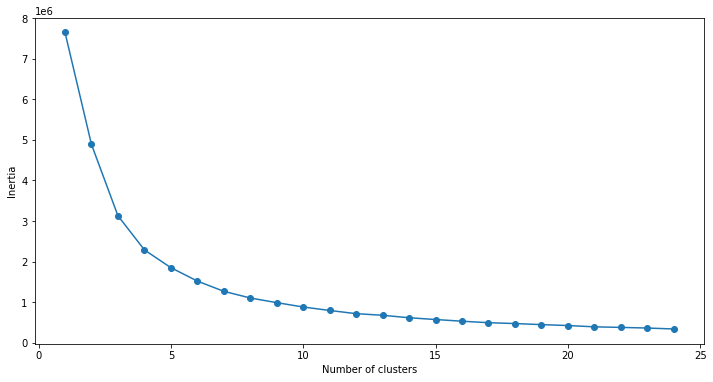

In [36]:
## using elbow plot to see reasonable number of clusters to use
# function for the elbow plot
def elbow_plot(model):
    model_tsne= tsne_transform(model)
    # fitting multiple k-means algorithms and storing the values in an empty list
    SSE = []
    for cluster in range(1,25):
        kmeans = KMeans(n_clusters = cluster, init='k-means++')
        kmeans.fit(model_tsne)
        SSE.append(kmeans.inertia_)

    # converting the results into a dataframe and plotting them
    frame = pd.DataFrame({'Cluster':range(1,25), 'SSE':SSE})
    plt.figure(figsize=(12,6))
    plt.plot(frame['Cluster'], frame['SSE'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

print("Elbow Plot for FastText Corpus A")
elbow_plot(modelNum_fasttext)
# optimal cluster is around 10

In [37]:
# using k-means to cluster
kmeans = KMeans(n_clusters = 10, init='k-means++')
kmeans.fit(modelNum_fasttext_tsne)
pred = kmeans.predict(modelNum_fasttext_tsne)

# computing the counts by using pandas function
frame = pd.DataFrame(modelNum_fasttext_tsne)
frame['cluster'] = pred
frame['cluster'].value_counts()

kmeans.inertia_

878539.625

In [38]:
# function returns cluster indices
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [39]:
# cluster list of words is shown in a list as indices
clusterNum_fasttext_tsne = ClusterIndicesNumpy(2, frame)
clusterNum_fasttext_tsne

array([   6,    8,   11,   29,   36,   47,   56,   66,   68,   71,   76,
         96,  105,  114,  125,  132,  147,  150,  155,  161,  183,  190,
        198,  202,  205,  206,  217,  222,  230,  238,  250,  255,  256,
        262,  263,  274,  277,  279,  287,  300,  305,  314,  321,  325,
        345,  355,  368,  370,  395,  404,  413,  417,  427,  459,  465,
        466,  476,  478,  484,  491,  514,  519,  522,  526,  534,  539,
        541,  565,  577,  582,  597,  601,  603,  608,  611,  615,  617,
        626,  630,  640,  641,  645,  651,  665,  675,  677,  691,  692,
        700,  716,  723,  731,  734,  735,  743,  749,  751,  771,  774,
        778,  784,  789,  790,  798,  801,  802,  807,  812,  814,  818,
        825,  826,  828,  829,  831,  849,  856,  871,  908,  922,  934,
        936,  940,  941,  943,  961,  973,  974,  975,  976,  977,  978,
        982,  990, 1037, 1038, 1049, 1076, 1077, 1082, 1091, 1095, 1096,
       1097, 1098, 1102, 1106, 1107, 1113, 1117, 11

In [40]:
print("First 2 words in cluster: ", modelNum_fasttext.wv.index_to_key[82],",", modelNum_fasttext.wv.index_to_key[109])
print("Words of index 82:",modelNum_fasttext.wv.index_to_key[82], " and index 109:", modelNum_fasttext.wv.index_to_key[109])

First 2 words in cluster:  tile , shearwall
Words of index 82: tile  and index 109: shearwall


In [41]:
# function to convert cluster index to words from the trained model
def index_to_words(cluster_indices, model):
    cluster_words = map(lambda index: model.wv.index_to_key[index],cluster_indices)
    return cluster_words

In [42]:
cluster_words = index_to_words(clusterNum_fasttext_tsne,modelNum_fasttext)
print(list(cluster_words))

['level', 'zone', 'plumbing', 'water', 'sanitary', 'pipe', 'cold', 'lift', 'hot', 'the', 'spine', 'mep', 'b2', 'staircase', 'ground', 'piping', 'l1', 'basement', 'b1', 'roof', 'm2', 'access', 'tc', 'signage', 'office', 'li', 'l2', 'residential', 'up', 'villa', 'steel', 'structure', 'mock', 'sl', 'lobby', 'no', 'elt', 'liftcore', 'b3', 'concourse', 'coldwater', 'p3a', 'toilet', 'semi', 'l30', 'platform', 'l3', 'lvl', 'architectural', 'pit', 'cubicle', 'carpark', 'refuse', 'l9', 'chamber', 'st', 'marking', 'escalator', 'a2', 'b4', 'barrel', 'fabrication', 'a3', 'p2a', 'encasement', 'truss', 'top', 'lvss', 'exit', 'levelling', 'bondek', 'ew', 'rainwater', 'l5', 'l6', 'l4', 'comment', 'l7', 'sewerage', 'l8', 'b12', 'a6', 'a5', 'stump', 'primary', 'lc', 'completed', 'a4', 'downpipe', 'micropile', 'roofing', 'backfilling', 'space', 'containment', 'unit', 'finalize', 'house', 'rwdp', 'emergency', 'sb', 'grd', 'rf', 'rwh', 'm1', 'b9', 'b11', 'type', 'anchor', 'kiosk', 'b5', 'b6', 'stressing', 

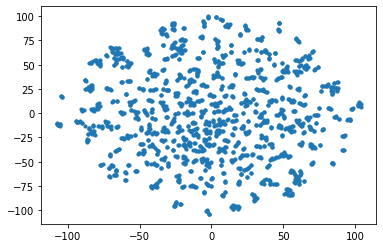

In [43]:
# # Project the data: this step will take several seconds
# from sklearn.cluster import KMeans
# tsne = TSNE(n_components=2, init='random', random_state=0)
# digits_proj = tsne_model

# # Compute the clusters
# kmeans = KMeans(n_clusters=50, random_state=0)
# clusters = kmeans.fit_transform(digits_proj)
# y_kmeans = kmeans.predict(digits_proj)
plt.scatter(modelNum_fasttext_tsne[:, 0], modelNum_fasttext_tsne[:, 1], s=10);

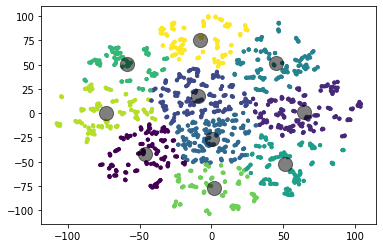

In [44]:
#Cluster with their centers shown as black dots
y_kmeans = kmeans.predict(modelNum_fasttext_tsne)
plt.scatter(modelNum_fasttext_tsne[:, 0], modelNum_fasttext_tsne[:, 1], c=y_kmeans, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', alpha=0.5);

## Clustering for the other models

In [45]:
# function for producing cluster plots
# model = model to use
# cluster_n = number of clusters
# cluster = specific cluster for its list of words
def kmeans_cluster_plot(model,cluster_n, cluster):
    # same clustering was done with other models
    model_tsne= tsne_transform(model)

    # using k-means to cluster
    kmeans = KMeans(n_clusters = cluster_n, init='k-means++')
    kmeans.fit(model_tsne)
    pred = kmeans.predict(model_tsne)
    y_kmeans = kmeans.predict(model_tsne)
    # computing the counts by using pandas function
    frame = pd.DataFrame(model_tsne)
    frame['cluster'] = pred
    frame['cluster'].value_counts()

    cluster_tsne = ClusterIndicesNumpy(cluster, frame)

    cluster_word_list = index_to_words(cluster_tsne,model)
    print(list(cluster_word_list))

    # clusters with their centers shown as black dots
    plt.scatter(model_tsne[:, 0], model_tsne[:, 1], c=y_kmeans, s=10, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', alpha=0.5);



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



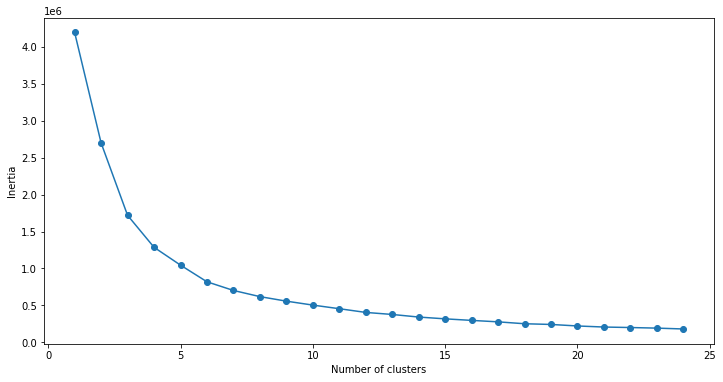

In [46]:
elbow_plot(modelAlp_fasttext)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



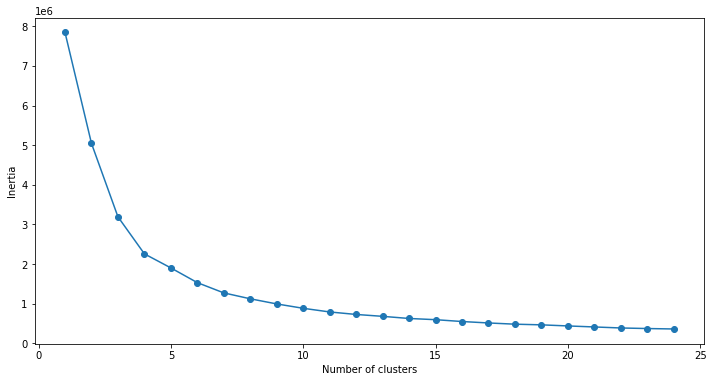

In [47]:
elbow_plot(modelNum)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



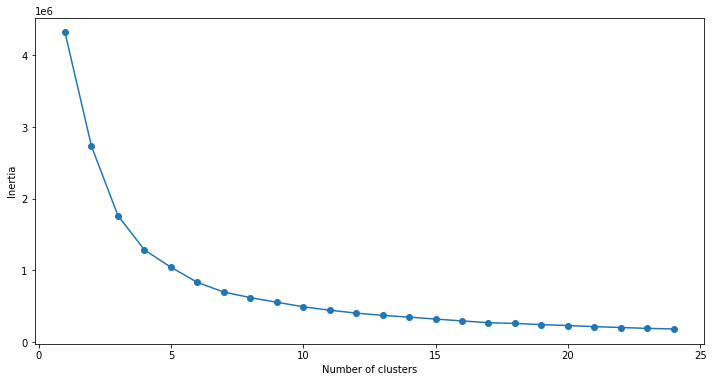

In [48]:
elbow_plot(modelAlp)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



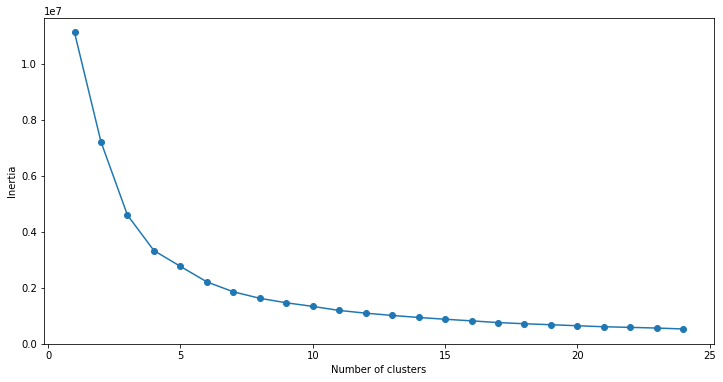

In [49]:
elbow_plot(modelNum_phrases)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



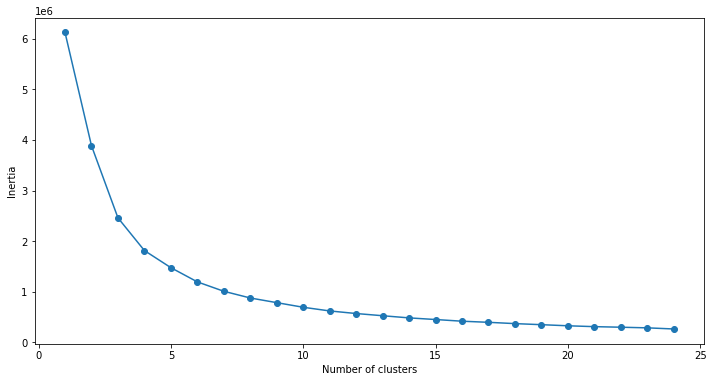

In [50]:
elbow_plot(modelAlp_phrases)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['of', 'facade', 'completion', 'block', 'and', 'plan', 'commencement', 'bracket', 'batch', 'station', 'liw', 'lighting', 'rail', 'certificate', 'cable', 'architecture', 'ccc', 'prep', 'guide', 'date', 'car', 'target', 'cm', 'compliance', 'acceptance', 'machine', 'physical', 'handover', 'gdc', 'nsc', 'survey', 'supervision', 'ca', 'ladder', 'by', 'north', 'alignment', 'tray', 'csd', 'entrance', 'fencing', 'traffic', 'elev', 'project', 'signing', 'telekom', 'cwt', 'speed', 'hoisting', 'roping', 'wire', 'syabas', 'superstructure', 'au', 'fee', 'stage', 'hydrant', 'fm', 'substructure', 'south', 'development', 'agreement', 'authority', 'street', 'leveling', 'anti', 'jalan', 'gbi', 'fc', 'counterweight', 'mobilization', 'klang', 'al1', 'al2', 'bl2', 'bl3', 'pl1', 'pl4', 'high', 'cwp', 'al3', 'al4', 'tw', 'cl4', 'cl1', 'cl2', 'bl1', 'cl3', 'sri', 'andalas', 'supervisory', 'iwk', 'soft', 'meru', 'cpc', 'termite', 'slow', 'good', 'besar', 'pasar', 'upon', 'kawasan', 'monitoring', 'make', 'instr

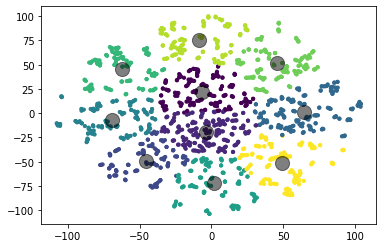

In [51]:
# clustering for modelNum_fasttext
kmeans_cluster_plot(modelNum_fasttext, 10, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['work', 'lift', 'completion', 'block', 'inspection', 'for', 'li', 'landscape', 'commencement', 'commissioning', 'wbb', 'road', 'bracket', 'podium', 'tnb', 'drainage', 'package', 'testing', 'bomba', 'l30', 'ready', 'liw', 'rail', 'parcel', 'certificate', 'pit', 'jkkp', 'over', 'cable', 'ccc', 'escalator', 'guide', 'from', 'date', 'car', 'handing', 'target', 'erection', 'passenger', 'crane', 'award', 'cm', 'compliance', 'acceptance', 'machine', 'physical', 'drain', 'dismantle', 'guard', 'overall', 'gdc', 'ca', 'tender', 'hoist', 'ladder', 'scaffolding', 'log', 'alignment', 'tray', 'entrance', 'bq', 'telekom', 'cwt', 'speed', 'hoisting', 'roping', 'cleaning', 'house', 'wire', 'culvert', 'syabas', 'superstructure', 'hydrant', 'substructure', 'course', 'movement', 'box', 'tree', 'paver', 'c3', 'sectional', 'snaglist', 'fc', 'counterweight', 'grass', 'motor', 'driveway', 'al1', 'al2', 'bl2', 'bl3', 'shrub', 'kerb', 'pl1', 'pl4', 'high', 'cwp', 'turfing', 'al3', 'al4', 'tw', 'cl4', 'cl1', 'c

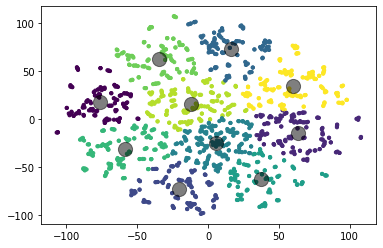

In [52]:
# clustering for modelNum
kmeans_cluster_plot(modelNum, 10, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['t', 'design', 'completion', 'dd', 'sh', 'id', 'and', 'preparation', 'tc', 'commencement', 'mechanical', 'commissioning', 'review', 'up', 'mock', 'fft', 'drawing', 'podium', 'toilet', 'testing', 'cn', 'cubicle', 'architecture', 'submittal', 'passenger', 'crane', 'cm', 'physical', 'dismantle', 'comment', 'overall', 'survey', 'hoist', 'pmu', 'by', 'vmu', 'log', 'fencing', 'hardscape', 'finalize', 'superstructure', 'receival', 'substructure', 'interior', 'softscape', 'civil', 'sectional', 'pantry', 'gbi', 'fc', 'benchmark', 'mobilization', 'ventilation', 'end', 'tw', 'prototype', 'ga', 'park', 'ph', 'conditioning', 'performance', 'user', 'mockup', 'inspected', 'disable', 'amendment', 'layout', 'document', 'section', 'setting', 'fl', 'concept', 'lake', 'janitor', 'walk', 'dilapidation', 'out', 'lining', 'through', 'planning', 'demarcation', 'plant', 'approved', 'stacking', 'clearance', 'posession', 'tca', 'perspective', 'pbsb', 'snetch', 'anticlimbing', 'schematic', 'acp', 'joint', 'guide

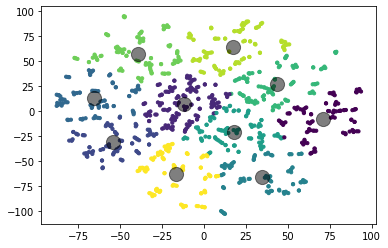

In [53]:
# clustering for modelAlp
kmeans_cluster_plot(modelAlp, 10, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['c', 'fitting', 'ar', 'l01', 'l02', 'l03', 'l04', 'l06', 'l08', 'l05', 'l07', 'room', 'p01', 'p02', 't', 'p03', 'door_frame', 'door', 'ironmongery', 'f11', 'archi', 'tile', 'l', 'jusa', 'f7', 'f6', 'plastering', 'l12_jusa', 'ar_d', 'floor_screed', 'gf', 'window', 'id', 'door_leaf', 'brickwall', 'cf_ceiling', 'window_dressing', 'lg', 'sanitary', 'loose_furniture', 'drywall_w', 'ft_floor', 'conceal_me', 'wt_wall', 'cjw', 'mechanical', 'jusa_b', 'ceiling_board', 'office_chair', 'brickwork', 'p3_painting', 'waterproofing', 'ar_cc', 'board', 'sn_signage', 'electrical_fft', 'plaster_ceiling', 'ar_pw', 'cb_ceiling', 'ceiling_tee', 'smatv_initial', 'b02', 'l13_jusa', 'built_in_furniture', 'wall_covering', 'l01_surau', 'wall_tile', 'b01', 'dd_approval', 'cn_preparation', 'dd_submission', 'dd_review', 'dd_preparation', 'l01_taska', 'ar_ice', 'av', 'dr_door', 'l33a', 'final_coat', 'ir_ironmongery', 'rl_m', 's_railing', 'leaf', 'bw_brickwork', 'df_door', 'l53a', 'pl_plastering', 'skw_skim', 'sks_

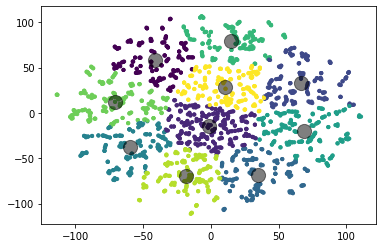

In [ ]:
# clustering for modelNum_phrases
kmeans_cluster_plot(modelNum_phrases, 10, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



['staircase', 'pa', 'concrete', 'liftcore', 'service', 'me', 'tpss', 'tnb', 'steel', 'steel_structure', 'no', 'column_encasement', 'room_refuse', 'chamber', 'lvss', 'ex', 'bondek', 'preliminary_month', 'covered_walkway', 'osd', 'semi_basement', 'pilecap_stump', 'csd_submission', 'roof_truss', 'elev_work', 'roofing', 'final', 'studio_aa', 'rf', 'primary_exit', 'mh', 'studio_ab', 'supervision_fee', 'rwh_t', 'kiosk', 'cable_containment', 'underground', 'laying', 'ms', 'refuse_chamber', 'syabas_cwp', 'hydrant', 'sp', 'ops_crew', 'layer', 'facade_north', 'mansory_work', 'gdc', 'on', 'ex_cw', 'mh_to_mh', 'wbb_relocation', 'facade_south', 'tier', 'ss', 'dismantling', 'swimming_pool', 'underpass', 'signing_agreement', 'agreement', 'traffic', 'upon_signing', 'col', 'access_micropile', 'aluminum_cladding', 'base', 'amendment', 'compaction', 'alternative_emergency', 'scaffold', 'water_proofing', 'micropile_no', 'inspection_from_authority', 'dr', 'bsa_bsa', 'manhole', 'tnb_col', 'tnb_sub', 'exit',

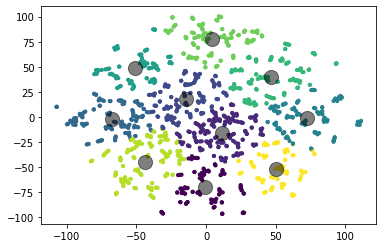

In [ ]:
# clustering for modelAlp_phrases
kmeans_cluster_plot(modelAlp_phrases, 10, 2)

# Unused/unfinished code

## TSNE plot for specific words


In [ ]:
# function for dimension reduction and plotting of word embedding models

def tsne_plot(model):
    labels = []
    wordvecs = []
    similar_word = []
    
    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
        model.wv.most_similar (positive=word, topn=5)
        
    for similar_word in word:    
        tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
        coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
vocab = ["cabling", "wiring", "cold", "hot", "wall", "painting", "door", "frame", "the", "spine", "t", "sys", "e", "m", "smatv", "fitting", "drawing", "dwg", "front", "receival", "tm", "building", "consulting"]
tsne_plot(modelNum)
vocab = ["cabling_wiring", "cold_hot", "wall", "painting", "door_frame", "the_spine", "t", "sys", "e", "m", "smatv", "dwg_ht", "air_cond", "drawing", "dwg_vert", "dwg_miscellaneous", "quality"]
tsne_plot(modelNum_phrases)


In [ ]:
vocab = ["cabling_wiring", "cold_hot", "wall", "painting", "door_frame", "the_spine", "t", "sys", "e", "m", "smatv", "p", "dwg_ht", "air_cond", "drawing", "dwg_vert", "dwg_miscellaneous", "quality"]
tsne_plot(model_phrases)


In [ ]:
# basic clusters
plt.scatter(modelNum_tsne[:, 0], modelNum_tsne[:, 1], s=10);

In [ ]:
# extracting the stopwords using nltk library
from nltk.corpus import stopwords
sw = stopwords.words('english')

def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

# the corpus is mostly the same as tokens_num except that the stopwords are removed
data_no_SW = data_lower
data_no_SW = data_no_SW.apply(stopwords)
data_no_SW = data_no_SW.apply(lemmatize_text)
data_no_SW.head(5)


# To Do
1. Label all selected vocabulary into certain labels 
2. Cluster by word vectors
3. Test its accuracy
4. Try OOV words for Fasttext model.

In [ ]:
for index, word in enumerate(modelNum_phrases.wv.index_to_key):
    if index == 2320:
        w2v_vocabulary
        break
w2v_vocabulary = modelNum.wv
w2v_vocabulary

In [ ]:
NUM_CLUSTERS = 30
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(modelNum_fasttext_tsne)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(tsne_model))
 
silhouette_score = metrics.silhouette_score(tsne_model, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

In [ ]:
from sklearn.cluster import KMeans
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=15, random_state=0).fit(word_cluster)
kmeans.labels_

In [ ]:
words = list(model_fasttext.wv.key_to_index)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))